# Lab9: RL: Value Iteration & Policy Iteration



This lab will guide you through **Value Iteration** and **Policy Iteration** on a small **Grid World**. You will learn how to solve Markov Decision Processes (MDPs) using dynamic programming methods. Starting with a custom Grid World environment, you will implement and compare two fundamental RL algorithms: Value Iteration and Policy Iteration. Finally, you will adapt your solution to work with the standard Gymnasium API.

**What You Will Learn:**

- **Task 1: Grid World Setup**  
    - Define an MDP with states, actions, transition dynamics, rewards, and discount factor.
    - Understand the `GridWorld` class structure and environment mechanics.
    - Visualize the environment with forbidden cells, goal states, and policies.

- **Task 2: Value Iteration**  
    - Implement the Value Iteration algorithm using the Bellman optimality equation.
    - Perform synchronous updates to compute optimal state values and policy.
    - Understand convergence criteria and interpret the resulting value function and policy.

- **Task 3: Policy Iteration**  
    - Implement Policy Evaluation to compute the value function for a given policy.
    - Implement Policy Improvement to update the policy greedily.
    - Compare Policy Iteration with Value Iteration in terms of iterations and computational cost.

- **Task 4: Using Gymnasium**  
    - Rewrite the Grid World environment following the Gymnasium API (`reset()`, `step()`, `render()`).
    - Understand action spaces (`Discrete`) and observation spaces (`MultiDiscrete`).
    - Implement Value Iteration for the Gymnasium-based environment and verify compatibility with standard RL frameworks.


In [ ]:

# Minimal prerequisites
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib: one chart per cell; no specific styles or colors set per instructions.
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)

NumPy: 2.0.2
Matplotlib: 3.10.0


## Task 1. Grid World Setup

We use a small rectangular grid to represent the environment. Each cell in the grid corresponds to a **state** that the agent can occupy. At each state, the agent can attempt one of five possible **actions**: up, right, down, left, or stay.

- **States**: A state is represented by a tuple `(row, column)`, indicating the agent's position. The grid is zero-indexed, so the top-left corner is `(0, 0)`.
- **Actions**: Actions are represented by integers from 0 to 4: `0` (up), `1` (right), `2` (down), `3` (left), and `4` (stay).
- **Transitions**: If an action moves the agent off the grid, the agent remains in its current state and receives a `boundary_reward`.
- **Rewards**: The environment provides different rewards based on the outcome of an action:
    - `goal_reward`: For reaching the goal state.
    - `forbidden_reward`: For entering a forbidden cell.
    - `boundary_reward`: For hitting a wall or boundary.
    - `step_reward`: For any other valid move.
- **Discount Factor (`gamma`)**: A value between 0 and 1 that balances the importance of immediate rewards versus future rewards.

The `GridWorld` class encapsulates this entire setup, managing the grid, states, actions, transitions, and rewards. A **class** in Python is a blueprint for creating objects. It bundles data (attributes) and functions that operate on that data (methods) into a single, organized unit. An object created from a class is called an instance.

In contrast, a **function** is a standalone block of code that performs a specific task. While functions can take inputs and produce outputs, they don't inherently store data or maintain a state between calls. A class, through its instances, can maintain its state (the values of its attributes) over time, making it ideal for representing complex entities like our `GridWorld` environment, which needs to keep track of its configuration (grid size, rewards, etc.) across multiple interactions.

In [ ]:
# Define actions and their visual representations
ACTIONS = [0, 1, 2, 3, 4]  # up, right, down, left, stay
ACTION_ARROWS = {0:"↑", 1:"→", 2:"↓", 3:"←", 4:"*"} # For rendering the policy

class GridWorld:
    """
    A class to represent the Grid World environment.
    Manages the grid, states, actions, transitions, and rewards.
    """
    def __init__(self,
                 grid_shape=(5, 5),  # number of rows and columns
                 forbidden=None,
                 goal=None,
                 goal_reward=10.0,
                 step_reward=0.0,
                 forbidden_reward=-1.0,
                 boundary_reward=-1.0,
                 gamma=0.9):
        """
        Initializes the GridWorld environment.

        Args:
            grid_shape (tuple): The (rows, columns) of the grid.
            forbidden (list): A list of (row, col) tuples for forbidden states.
            goal (tuple): The (row, col) of the goal state.
            goal_reward (float): Reward for reaching the goal.
            step_reward (float): Reward for a standard step.
            forbidden_reward (float): Penalty for entering a forbidden state.
            boundary_reward (float): Penalty for hitting a wall or boundary.
            gamma (float): The discount factor for future rewards.
        """
        self.grid_shape = grid_shape
        # Default locations for forbidden cells and the goal if not provided
        self.forbidden = forbidden if forbidden is not None else [(1,1), (1,2),(2,2), (3,1), (3,3) ,(4,1)] # Example forbidden positions
        self.goal = goal if goal is not None else (3,2) # Example goal position

        # Reward structure
        self.goal_reward = goal_reward
        self.step_reward = step_reward
        self.forbidden_reward = forbidden_reward
        self.boundary_reward = boundary_reward

        # Discount factor
        self.gamma = gamma

    def in_bounds(self, s):
        """Check if a state 's' is within the grid boundaries."""
        r, c = s # r is the row, c is the column
        R, C = self.grid_shape # Total rows and columns
        return 0 <= r < R and 0 <= c < C # if within bounds then return True

    def is_forbidden(self, s):
        """Check if a state 's' is a forbidden cell."""
        return s in self.forbidden # if s is in forbidden list then return True

    def states(self):
        """Returns a list of all states in the grid."""
        R, C = self.grid_shape
        return [(r, c) for r in range(R) for c in range(C)]

    def step(self, s, a):
        """
        Performs a state transition based on the current state and action.
        This function defines the environment's dynamics.

        Args:
            s (tuple): The current state (row, col).
            a (int): The action to take.

        Returns:
            tuple: A tuple containing the next state (next_s) and the reward.
        """
        assert a in ACTIONS, f"Invalid action: {a}. Valid actions are: {ACTIONS}"

        r, c = s
        # Determine the next potential position based on the action
        if a == 0:    nr, nc = r-1, c    # up
        elif a == 1:  nr, nc = r, c+1    # right
        elif a == 2:  nr, nc = r+1, c    # down
        elif a == 3:  nr, nc = r, c-1    # left
        else:         nr, nc = r, c      # stay

        # Check for boundary collisions or walls
        if (not self.in_bounds((nr, nc))):
            next_s = s  # Agent stays in the same state
            reward = self.boundary_reward
        else:
            # The move is valid, so the agent moves to the new position
            next_s = (nr, nc)
            # Determine the reward based on the new state
            if next_s == self.goal:
                reward = self.goal_reward
            elif self.is_forbidden(next_s):
                reward = self.forbidden_reward
            else:
                reward = self.step_reward

        return next_s, reward


### Visualization helpers

- `plot_values(V)`: Creates a heatmap to visualize the value of each state. Higher values are typically shown in brighter colors, providing an intuitive overview of which states are more desirable for the agent.
- `render_policy(P)`: table of arrows showing the greedy action per state.


In [ ]:
ACTION_ARROWS = {
    0: "↑",   # down
    1: "→",   # right
    2: "↓",   # up
    3: "←",   # left
    4: "•",   # stay
}

def render_policy_with_values(env, P, V=None, title="Policy and Values", ax=None, show=True):
    """
    Renders the greedy policy as arrows and overlays the value for each state in a matplotlib plot.

    Args:
        env: GridWorld environment object. Should provide .grid_shape and .is_forbidden().
        P (dict): The policy mapping states (r, c) to actions (int).
        V (dict): Optional. A dictionary mapping states to their values.
        title (str): Title of the plot.
        ax: Optional matplotlib axes object. If provided, plots on this axes instead of creating a new figure.
        show (bool): Whether to call plt.show() at the end. Default True. Set False when creating subplots.

    Returns:
        tuple: (fig, ax) - The figure and axes objects.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    R, C = env.grid_shape
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
    else:
        fig = ax.figure
    ax.set_xlim(-0.5, C - 0.5)
    ax.set_ylim(-0.5, R - 0.5)
    ax.set_xticks(np.arange(-0.5, C, 1))
    ax.set_yticks(np.arange(-0.5, R, 1))
    ax.grid(True, color='gray', linewidth=1, linestyle='-')
    ax.set_aspect('equal')
    ax.invert_yaxis()  # Match array indexing

    # Draw cell highlights for forbidden/goal/start
    for r in range(R):
        for c in range(C):
            s = (r, c)
            if env.is_forbidden(s):
                rect = plt.Rectangle((c-0.5, r-0.5), 1, 1, color='gray', alpha=0.5)
                ax.add_patch(rect)
                ax.text(c, r, "X", ha='center', va='center', color='black', fontsize=14)
            elif s == env.goal:
                rect = plt.Rectangle((c-0.5, r-0.5), 1, 1, color='yellow', alpha=0.45)
                ax.add_patch(rect)
                ax.text(c, r, "G", ha='center', va='center', color='black', fontsize=14)
            elif s == getattr(env, "start_state", None):
                rect = plt.Rectangle((c-0.5, r-0.5), 1, 1, color='deepskyblue', alpha=0.35)
                ax.add_patch(rect)
                ax.text(c, r, "S", ha='center', va='center', color='black', fontsize=14)

    # Print arrows and values in every cell (except forbidden)
    for r in range(R):
        for c in range(C):
            s = (r, c)
            # Print policy arrow
            if (r, c) in P:
                arrow = ACTION_ARROWS[P[(r, c)]]
            else:
                arrow = ""
            if (V is not None) and ((r, c) in V):
                valstr = f"{V[(r, c)]:.2f}"
            else:
                valstr = ""
            # Place arrow in cell
            ax.text(
                c, r-0.18, arrow,
                ha='center', va='center', color='darkblue', fontsize=22, fontweight='bold', zorder=10
            )
            # Always show value in each cell (if provided), not just if valstr != ""
            ax.text(
                c, r+0.27, valstr if valstr != "" else "",
                ha='center', va='center', color='crimson', fontsize=11, alpha=0.99,
                bbox=dict(facecolor="white", alpha=0.63, edgecolor='none', boxstyle='round,pad=0.16'),
                zorder=10
            )

    # Label grid
    for x in range(C):
        ax.text(x, -0.75, str(x+1), ha='center', va='center', color='black')
    for y in range(R):
        ax.text(-0.75, y, str(y+1), ha='center', va='center', color='black')

    ax.set_title(title)
    ax.tick_params(bottom=False, left=False, right=False, top=False,
                   labelbottom=False, labelleft=False, labeltop=False, labelright=False)
    if show:
        plt.tight_layout()
        plt.show()

    return fig, ax

## Task 2. Value Iteration

We first implement value iteration to find the **optimal value function** ($v^*$) and the **optimal policy** ($\pi^*$). The value function $v^*(s)$ tells us the maximum expected future return an agent can get starting from state $s$. The policy $\pi^*(s)$ tells us the best action to take in state $s$.

These are found by solving the **Bellman Optimality Equation**. For our deterministic Grid World, this equation simplifies to:

$$
v^*(s) = \max_{a \in A} \Big[ r(s,a) + \gamma v^*(s') \Big]
$$

where:
- $s$ is the current state.
- $a$ is a possible action.
- $s'$ is the state you land in after taking action $a$ from state $s$.
- $r(s,a)$ is the immediate reward.
- $\gamma$ (gamma) is the discount factor, which balances immediate vs. future rewards.


### Algorithm

Value Iteration finds the optimal value function and policy by repeatedly applying the Bellman optimality equation. The algorithm iterates, updating both the value estimates and the policy at each step until convergence.

**1. Initialization**
- Initialize an arbitrary value function $v_0(s)$ for all states $s$ (e.g., all zeros).
- Choose a small positive number `theta` ($\theta$) to check for convergence.

**2. Iteration and Synchronous Updates**
   
Repeat for each iteration $k=0, 1, 2, \dots$ until convergence:

- For every state $s \in S$:
    - **a. Compute Action-Values (q-values)**: For each possible action $a$, calculate its value using the value function from the *previous* iteration, $v_k$:
      $$
      q_k(s,a) = r(s,a) + \gamma v_k(s')
      $$
    - **b. Find Best Action**: Identify the best action $a_k^{*}(s)$ that maximizes the q-value:
      $$
      a_k^{*}(s) = \arg\max_{a} q_k(s,a)
      $$
    - **c. Update Policy**: Update the policy for the next iteration, $\pi_{k+1}$, to be greedy with respect to the q-values:
      $$
      \pi_{k+1}(s) = a_k^*(s)
      $$
    - **d. Update State-Value**: Update the state-value for the next iteration, $v_{k+1}$, with the value of the best action:
      $$
      v_{k+1}(s) = \max_{a} q_k(s,a)
      $$

**3. Convergence Check**
   
The algorithm has converged when the largest change in any state's value is less than `theta`:
$$
\max_{s \in S} |v_{k+1}(s) - v_k(s)| < \theta
$$
Once converged, $v_{k+1}$ and $\pi_{k+1}$ are the optimal value function $v^*$ and optimal policy $\pi^*$.

Value Iteration converged in 89 iterations.


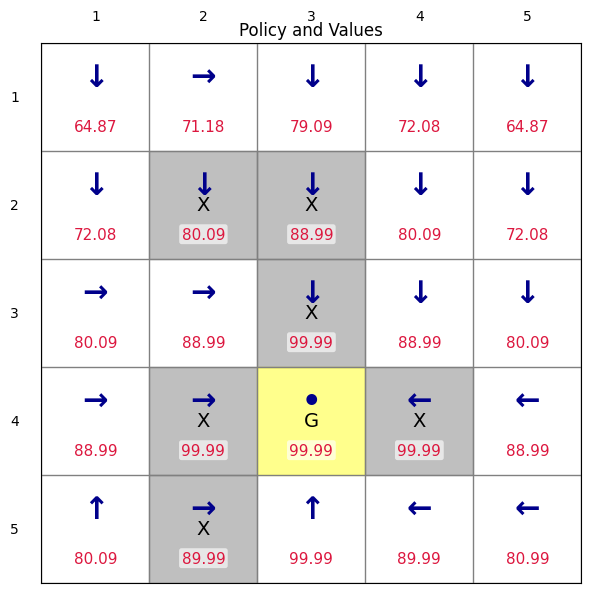

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Policy and Values'}>)

In [ ]:
def value_iteration(env, theta, max_iters):
    """
    Performs Value Iteration to find the optimal value function and policy,
    following the structure of the provided pseudocode.

    Args:
        env: The GridWorld environment.
        theta (float): A small threshold for determining convergence.
        max_iters (int): The maximum number of iterations to prevent infinite loops.

    Returns:
        tuple: A tuple containing:
            - V (dict): The optimal value function, mapping states to values.
            - Pi (dict): The optimal policy, mapping states to actions.
            - iters (int): The number of iterations until convergence.
    """
    # Initialization: Initial guess v0
    V = {s: 0.0 for s in env.states()}
    Pi = {s: 0 for s in env.states()} # Policy can be initialized arbitrarily
    iters = 0

    while True:
        delta = 0.0
        V_old = V.copy() # Store vk to calculate delta = ||vk - vk-1||

        # For every state s ∈ S, do
        for s in env.states():
            # For every action a ∈ A(s), do
            # q-value: qk(s, a) = r(s,a) + γ * V(s')
            q_values = {}
            for a in ACTIONS:
                s_next, r = env.step(s, a) # Get next state and reward
                q_values[a] = r + env.gamma * V_old[s_next] # get the action value

            # Maximum action value: a*k(s) = arg maxa qk(a, s)
            best_action = max(q_values, key=q_values.get)

            # Value update: vk+1(s) = maxa qk(a, s)
            best_value = q_values[best_action]
            V[s] = best_value

            # Policy update: πk+1(s) = a*k(s)
            Pi[s] = best_action

            # Check for convergence
            delta = max(delta, abs(V[s] - V_old[s]))

        iters += 1
        if delta < theta or iters >= max_iters:
            break

        # Show intermediate policy and values during value iteration
        # if iters % 20 == 0 or delta < theta:  # Visualize every 10 steps and at convergence
        #     render_policy_with_values(env, Pi, V, title=f"Value Iteration Step {iters}")
        #     import time
        #     time.sleep(1)
        #     plt.close('all')  # Close all existing figures before drawing a new one
    return V, Pi, iters

# Demo run
env = GridWorld()
V_vi, Pi_vi, n_vi = value_iteration(env, 1e-3, 1000)
print(f"Value Iteration converged in {n_vi} iterations.")
render_policy_with_values(env, Pi_vi, V_vi, title="Policy and Values")


## Task 3. Policy Iteration

We then implement policy interation to find the optimal policy $\pi^*$ and its corresponding value function $v^*$ through an iterative process that alternates between two main steps:

- **Policy Evaluation**: For a given policy $\pi$, calculate the state-value function $v_\pi$. This step determines the expected long-term return for each state, assuming the agent follows the current policy $\pi$.
- **Policy Improvement**: Using the value function $v_\pi$, find a new, better policy $\pi'$. This is done by acting greedily with respect to $v_\pi$—that is, for each state, selecting the action that leads to the highest expected return.

This cycle of evaluation and improvement continues until the policy no longer changes, at which point it has converged to the optimal policy.

### **Algorithm**

**1. Initialization**
- Initialize a **policy** $\pi_0(s)$ arbitrarily for all states $s \in S$.  
- Initialize the **state-value function** $v(s)$ arbitrarily (e.g., zeros).  
- Set iteration counter $k = 0$.

**2. Policy Evaluation**

Given the current policy $\pi_k$, compute its value function $v^{\pi_k}$ by solving the **Bellman equation**:

$$
v_{\pi_k}(s)
= \sum_a \pi_k(a|s)
  \Big[
    r(s,a)
    + \gamma \sum_{s'} p(s'|s,a)\, v_{\pi_k}(s')
  \Big].
$$

We usually **solve it iteratively** until convergence:

$$
v_{i+1}(s)
\leftarrow
\sum_a \pi_k(a|s)
\Big[
  r(s,a)
  + \gamma \sum_{s'} p(s'|s,a)\, v_i(s')
\Big].
$$

Stop when $\|v_{i+1} - v_i\|_\infty < \theta$ or when $i$ is large than a given value.


**3. Policy Improvement**

Update the policy greedily with respect to $v^{\pi_k}$:

$$
\pi_{k+1}(s)
= \arg\max_a
\Big[
  r(s,a)
  + \gamma \sum_{s'} p(s'|s,a)\, v^{\pi_k}(s')
\Big].
$$

**4. Termination Check**

If $\pi_{k+1} = \pi_k$ (i.e., policy no longer changes),  
then the algorithm has **converged**:

$$
\pi^* = \pi_k,\quad v^* = v^{\pi_k}.
$$

Otherwise, set $k \leftarrow k+1$ and repeat.

Policy Iteration converged in 6 improvement steps.


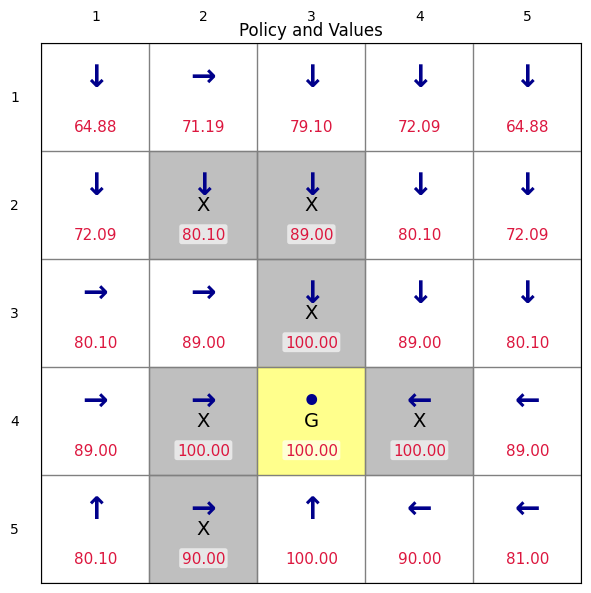

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Policy and Values'}>)

In [ ]:
def policy_evaluation(env, Pi, theta, max_iters):
    """
    Calculates the state-value function V for a given policy Pi.
    This is an iterative process that applies the Bellman equation until V converges.

    Args:
        env (GridWorld): The environment.
        Pi (dict): The policy to evaluate, mapping states to actions.
        theta (float): Convergence threshold. The loop stops when the max change in V is less than this.
        max_iters (int): Maximum number of iterations to prevent infinite loops.

    Returns:
        tuple: A tuple containing:
            - V (dict): The converged state-value function for the policy Pi.
            - iters (int): The number of iterations it took to converge.
    """
    # Initialize the value function V(s) = 0 for all states s.
    V = {s: 0.0 for s in env.states()}

    iters = 0
    while True:
        delta = 0.0  # Tracks the maximum change in V in a single sweep.
        V_old = V.copy() # Store the old value function for comparison.

        # Loop through each state to update its value.
        for s in env.states():
            # Get the action prescribed by the current policy for state s.
            a = Pi[s]

            # Get the next state and reward for the (s, a) pair.
            s_next, r = env.step(s, a)

            # Apply the Bellman equation for the given policy:
            # V(s) = R(s, a) + gamma * V(s_next)
            # This calculates the expected return from state s by following policy Pi.
            val = r + env.gamma * V_old[s_next]

            # Update the value for the current state.
            V[s] = val

            # Check for convergence by tracking the largest change in V.
            delta = max(delta, abs(val - V_old[s]))

        iters += 1
        # If the value function has stabilized, or we've hit the max iterations, stop.
        if delta < theta or iters >= max_iters:
            break

    return V, iters

def policy_improvement(env, V):
    """
    Improves a policy by making it greedy with respect to a given value function V.

    Args:
        env (GridWorld): The environment.
        V (dict): The value function to be greedy upon.

    Returns:
        dict: The new, improved policy.
    """
    Pi_new = {} # Initialize the new policy.

    # Iterate over all states to find the best action for each.
    for s in env.states():
        q_values = {}
        # For each state, calculate the Q-value for all possible actions.
        for a in ACTIONS:
            s_next, r = env.step(s, a)
            # Q(s, a) = R(s, a) + gamma * V(s_next)
            q_values[a] = r + env.gamma * V[s_next]

        # The new policy for state s will be the action that maximizes the Q-value.
        best_a = max(q_values, key=q_values.get)
        Pi_new[s] = best_a

    return Pi_new

def policy_iteration(env, theta, max_iters):
    """
    Performs Policy Iteration to find the optimal policy and value function.
    It alternates between Policy Evaluation and Policy Improvement until the policy converges.

    Args:
        env (GridWorld): The environment.
        theta (float): Convergence threshold for policy evaluation.
        max_iters (int): Maximum number of policy improvement steps.

    Returns:
        tuple: A tuple containing:
            - V (dict): The optimal value function.
            - Pi (dict): The optimal policy.
            - iteration (int): The number of policy improvement steps.
    """

    # Start with a random initial policy.
    # For each state, choose a random action from the set of possible actions.
    Pi = {s: np.random.choice(ACTIONS) for s in env.states()}
    iteration = 0

    while True:
        # Step 1: Policy Evaluation
        V, _ = policy_evaluation(env, Pi, theta, max_iters)

        # Step 2: Policy Improvement
        Pi_new = policy_improvement(env, V)
        iteration += 1

        # Step 3: Termination Check
        if Pi_new == Pi or iteration >= max_iters:
            break

        # Update the policy for the next iteration of the main loop.
        Pi = Pi_new

    # Return the final converged value function, policy, and number of iterations.
    return V, Pi_new, iteration

# --- Demo Run ---
# Create a new GridWorld instance for this demonstration.
env2 = GridWorld()

# Run the Policy Iteration algorithm.
V_pi, Pi_pi, iteration = policy_iteration(env2, theta=1e-5, max_iters=1000)

# Print the results and visualize the value function and policy.
print(f"Policy Iteration converged in {iteration} improvement steps.")
render_policy_with_values(env, Pi_pi, V_pi, title="Policy and Values")


#### Comparing the Algorithms

- **Value Iteration:**
  - Performs a single Bellman optimality backup for every state in each iteration. This step simultaneously improves the value estimate and the implicit policy.
  - Each iteration is computationally fast, involving a single sweep through the state space.
  - It often requires a larger number of iterations to converge compared to the number of policy improvement steps in Policy Iteration.

- **Policy Iteration:**
  - Alternates between two distinct steps:
    1. **Policy Evaluation:** Fully computes the value function for the current policy until it converges. This step can be computationally expensive.
    2. **Policy Improvement:** Updates the policy to be greedy with respect to the newly computed value function.
  - It typically converges in fewer overall iterations (policy improvement steps), but each iteration is more computationally intensive due to the full policy evaluation.

Value Iteration: 133 iterations
Policy Iteration: 5 iterations


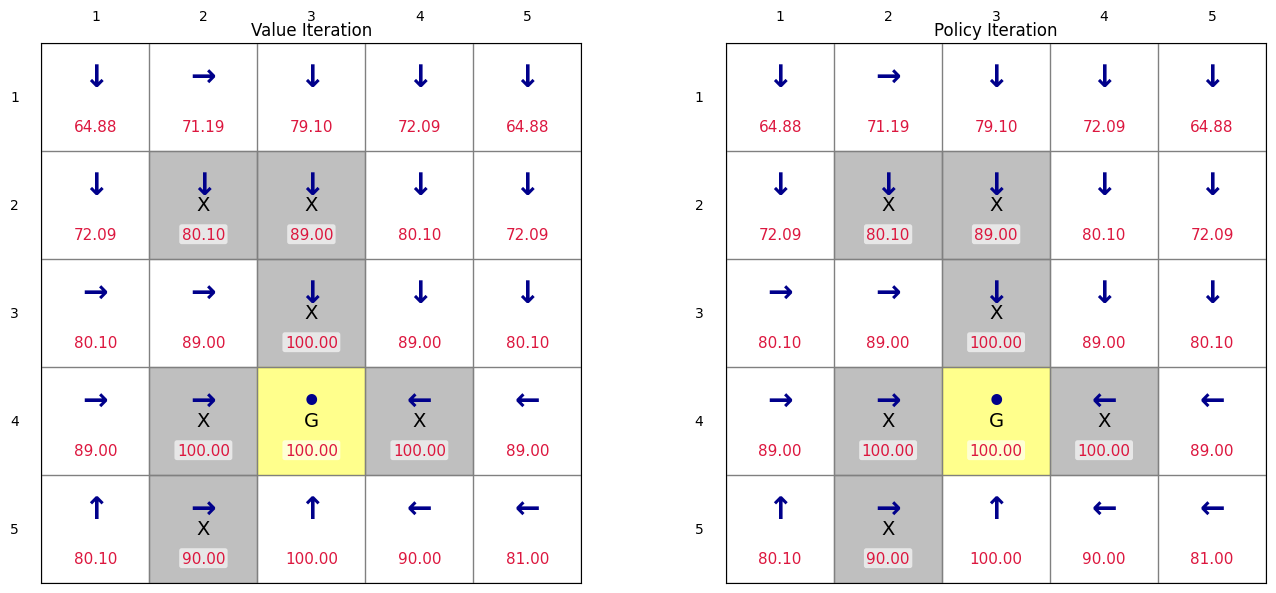

In [ ]:
# Quick side-by-side run for the same environment:
env_cmp = GridWorld(gamma=0.9)

V_vi, Pi_vi, n_vi = value_iteration(env_cmp, theta=1e-5, max_iters=1000)
V_pi, Pi_pi, n_pi = policy_iteration(env_cmp, theta=1e-5, max_iters=1000)

print(f"Value Iteration: {n_vi} iterations")
print(f"Policy Iteration: {n_pi} iterations")

import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Policy from Value Iteration (left subplot)
render_policy_with_values(env_cmp, Pi_vi, V_vi, title="Value Iteration", ax=axes[0], show=False)

# Plot Policy from Policy Iteration (right subplot)
render_policy_with_values(env_cmp, Pi_pi, V_pi, title="Policy Iteration", ax=axes[1], show=False)

plt.tight_layout()
plt.show()


## Task 4: Using Gymansium

We now re-write the grid world environment following the Gymnasium API. Gymnasium provides a standardized API (reset(), step(), render()) that allows seamless integration with popular RL libraries such as `Stable-Baselines3`. As one of the most widely used frameworks in reinforcement learning, Gymnasium offers a common interface shared by countless research projects and benchmarks. Using it ensures that our environment is compatible, reproducible, and easy to compare with other RL studies.

The Gymnasium API is built around a few core components that define the interaction between an agent and its environment.

- `gym.make(id)`: This function creates and initializes an environment specified by its id. It's the standard entry point for loading any of the built-in or custom-registered environments.

- `env.reset()`: This method resets the environment to a valid starting state and returns the initial observation. This is called at the beginning of every new episode.

- `env.step(action)`: This is the most important method. It executes the agent's chosen action for one time-step. In return, it provides a tuple of five crucial pieces of information: the next observation, the reward received, a boolean flag indicating if the episode has terminated (e.g., the goal was reached), a boolean flag indicating if the episode was truncated (e.g., a time limit was hit), and a dictionary containing diagnostic info.

- `env.render()`: This method generates a visualization of the environment's current state. It's invaluable for watching your agent perform during evaluation or for debugging your code.

Details can be found at [Basic Usage of Gym](https://gymnasium.farama.org/introduction/basic_usage/).

In Gymnasium, an **action space** defines what moves or commands an agent can take — for example, in GridWorld, actions are discrete choices such as up, right, down, left, or stay.
The **observation space** describes what the agent perceives about the environment at each step — in this case, it is the agent’s position on the grid, represented by row and column indices.  

A **Discrete** action space means the agent selects one action from a finite set of integers. Discrete(4) means the action can choose from five consecutive integers starting from 0, that is 0\~4.  In our grid world environment, 0, 1, 2 , 3, 4 means up, right, down, left, stay, respectively.
A **MultiDiscrete** observation space means the observation or state has multiple integer components, each with its own range — for instance, Discrete([4,4]) means both values can choose from five integers [0\~4, 0\~4]. In our grid world environment, the two numbers represent the row and column indices of the cell position. For instance, [2,3] means the cell position at row 2 and column 3.

The function `tuple(s_next)` converts the NumPy array returned by the environment (like `[2, 3]`) into a tuple `(2, 3)` so it can be used as a dictionary key when storing or retrieving state values.


In [ ]:
try:
    import gymnasium as gym
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install gymnasium
    import gymnasium as gym
from gymnasium import spaces # spaces are used to define action and observation spaces
import numpy as np

# Define the set of possible actions and their visual representations
ACTIONS = [0, 1, 2, 3, 4]  # up, right, down, left, stay
ACTION_ARROWS = {0:"↑", 1:"→", 2:"↓", 3:"←", 4:"*"}


class GridWorldEnv(gym.Env):
    """Custom GridWorld environment compatible with Gymnasium API."""
    """Note that Gymnasium environments are typically implemented as classes that inherit from gym.Env.
    This allows them to integrate seamlessly with the Gymnasium framework,
    which provides tools for reinforcement learning research and development."""
    """You may compare this class with the one implemented at the beginning as a simple GridWorld class.
    The only difference is that this class follows the Gymnasium API requirements: it defines action_space and observation_space,
    and implements reset() and step() methods."""

    def __init__(self,
                 grid_shape=(5, 5),
                 forbidden=None,
                 goal=None,
                 goal_reward=1.0,
                 step_reward=0.0,
                 forbidden_reward=-10.0,
                 boundary_reward=-1.0,
                 gamma=0.9,
                 render_mode=None):
        """
        Initializes the GridWorld environment.

        Args:
            grid_shape (tuple): The shape of the grid (rows, columns).
            forbidden (list of tuples): A list of coordinates for forbidden states.
            goal (tuple): The coordinates of the goal state.
            goal_reward (float): The reward for reaching the goal.
            step_reward (float): The reward for a regular step.
            forbidden_reward (float): The reward for entering a forbidden state.
            boundary_reward (float): The reward for hitting a boundary.
            gamma (float): The discount factor for future rewards.
            render_mode (str, optional): The mode for rendering the environment.
        """
        super().__init__()

        # Environment parameters
        self.grid_shape = grid_shape
        self.forbidden = forbidden if forbidden is not None else [(2,2)]
        self.goal = goal if goal is not None else (4,4)
        self.goal_reward = goal_reward
        self.step_reward = step_reward
        self.forbidden_reward = forbidden_reward
        self.boundary_reward = boundary_reward
        self.gamma = gamma
        self.render_mode = render_mode

        # Agent's current position, initialized in reset()
        self.agent_pos = None

        # Define Gymnasium spaces
        # The action space is discrete with a size equal to the number of actions.
        self.action_space = spaces.Discrete(len(ACTIONS))
        # The observation space represents the agent's position on the grid.
        self.observation_space = spaces.MultiDiscrete(list(grid_shape))

    # -----------------------------------
    # Helper functions
    # -----------------------------------
    def in_bounds(self, s):
        """Check if a state 's' is within the grid boundaries."""
        r, c = s
        R, C = self.grid_shape
        return 0 <= r < R and 0 <= c < C

    def is_forbidden(self, s):
        """Check if a state 's' is a forbidden state."""
        return s in self.forbidden

    def states(self):
        """Return a list of all possible states (coordinates) in the grid."""
        valid_states = []
        R, C = self.grid_shape
        for r in range(R):
            for c in range(C):
                valid_states.append((r,c))
        return valid_states

    # -----------------------------------
    # Gymnasium required methods
    # -----------------------------------

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        The agent is placed at the starting position (0,0).
        Returns the initial observation and an info dictionary.
        """
        super().reset(seed=seed)
        self.agent_pos = (0, 0)   # Always start in the top-left corner
        # The observation is the agent's position as a numpy array.
        obs = np.array(self.agent_pos, dtype=np.int32)
        return obs, {}

    def step(self, action):
        """
        Execute one time step in the environment.
        The agent takes an action, and the environment transitions to a new state.

        Args:
            action (int): The action to be taken by the agent.

        Returns:
            tuple: A tuple containing the new observation, the reward,
                   a boolean indicating if the episode is terminated,
                   a boolean indicating if the episode is truncated,
                   and an info dictionary.
        """
        assert self.action_space.contains(action), f"Invalid action {action}"

        r, c = self.agent_pos

        # Map the action to a new position (nr, nc for new row, new col)
        if action == 0:    nr, nc = r - 1, c     # up
        elif action == 1:  nr, nc = r, c + 1     # right
        elif action == 2:  nr, nc = r + 1, c     # down
        elif action == 3:  nr, nc = r, c - 1     # left
        else:              nr, nc = r, c         # stay

        # Check for environment boundaries
        if not self.in_bounds((nr, nc)):
            next_pos = self.agent_pos  # Agent stays in the same position
            reward = self.boundary_reward
        else:
            # The new position is valid
            next_pos = (nr, nc)
            # Assign reward based on the new state
            if next_pos == self.goal:
                reward = self.goal_reward
            elif self.is_forbidden(next_pos):
                reward = self.forbidden_reward
            else:
                reward = self.step_reward

        # Update the agent's position
        self.agent_pos = next_pos

        # Prepare the return values
        obs = np.array(self.agent_pos, dtype=np.int32)

        # In this simple environment, an episode never terminates or gets truncated on its own.
        # This would be different in environments with terminal states or time limits.
        terminated, truncated, info = False, False, {}

        return obs, reward, terminated, truncated, info

Now, let's implement the value iteration algorithm based on this Gymnaiusm-style grid world environment. The policy iteration algorithm is left as an exercise.

Value Iteration converged in 67 iterations.


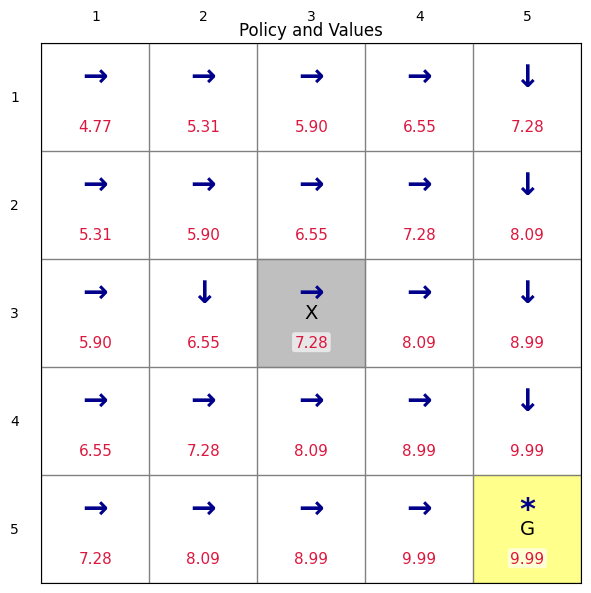

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Policy and Values'}>)

In [ ]:
def value_iteration_gym(env, theta, max_iters):
    """
    Performs Value Iteration for a Gymnasium-based GridWorld environment.
    This implementation is similar to the one in Task 2.

    Args:
        env (GridWorldEnv): The Gymnasium-style GridWorld environment.
        theta (float): A small threshold for determining convergence.
        max_iters (int): The maximum number of iterations.

    Returns:
        tuple: A tuple containing:
            - V (dict): The optimal value function.
            - Pi (dict): The optimal policy.
            - iters (int): The number of iterations until convergence.
    """
    # Initialization
    states = env.states()
    V = {s: 0.0 for s in states}
    Pi = {s: 0 for s in states}  # Arbitrary initial policy
    iters = 0

    while True:
        delta = 0.0
        V_old = V.copy()  # Store the value function from the previous iteration

        # Loop over all states
        for s in states:
            q_values = {}
            # Calculate the q-value for each action in the current state
            for a in ACTIONS:
                # The Gym env is stateful, so we need to set its position to the state 's' we are evaluating
                env.agent_pos = s
                # The step function returns the next state and reward
                s_next_arr, r, _, _, _ = env.step(a)
                s_next = tuple(s_next_arr) # Convert numpy array to tuple for dict key

                # Bellman update using the value function from the *previous* iteration
                q_values[a] = r + env.gamma * V_old[s_next]

            # Find the best action and its value
            best_action = max(q_values, key=q_values.get)
            best_value = q_values[best_action]

            # Update the value function and policy for the current state
            V[s] = best_value
            Pi[s] = best_action

            # Track the maximum change in the value function for convergence check
            delta = max(delta, abs(V[s] - V_old[s]))

        iters += 1
        # Check for convergence
        if delta < theta or iters >= max_iters:
            break

    return V, Pi, iters

# ---- Demo Run ----
env = GridWorldEnv()
V_vi, Pi_vi, n_vi = value_iteration_gym(env, theta=1e-3, max_iters=1000)
print(f"Value Iteration converged in {n_vi} iterations.")
render_policy_with_values(env, Pi_vi, V_vi, title="Policy and Values")


## HW Problems

1. **Value Iteration Manual derivation**: Consider a 2×2 grid world with the following configuration:
   
   |      |   0   |   1   |
   |------|-------|-------|
   | **0** | [   ] | [ G ] | ← Goal      |
   | **1** | [   ] | [ X ] | ← Forbidden |

   - Goal state: (0,1) - marked with "G"
   - Forbidden state: (1,1) - marked with "X"
   - Rewards:
      - goal_reward = 10.0 (for reaching the goal)
      - step_reward = -0.1 (small penalty for each step)
      - forbidden_reward = -5.0 (penalty for entering forbidden state)
      - boundary_reward = -1.0 (penalty for hitting boundary)
   - Discount factor: gamma = 0.9

   Assume we have five actions for each state similar to the example we discussed in lectures. Manually perform Value Iteration to find the optimal value function $v(s)$ and optimal policy $\pi(s)$ for all states. Show the details steps.

2. **Policy Iteration Manual derivation**: consider a 1x2 grid world with the following configuration:
   |      |   0   |   1   |
   |------|-------|-------|
   | **0** | [ G ] | [  ] |
   - Goal state: (0,0) - marked with "G"
   - Rewards:
      - goal_reward = 5.0 (for reaching the goal)
      - step_reward = -0.1 (small penalty for each step)
      - boundary_reward = -1.0 (penalty for hitting boundary)
   - Discount factor: gamma = 0.9

   Assume we have three actions $a_l$, $a_0$, and $a_r$ for moving left, stay, and moving right. Manually perform Policy Iteration to find the optimal value function $v(s)$ and optimal policy $\pi(s)$ for all states. **Assuming an initial policy that will both move to the right**.  Show the details steps (note that in the policy evaluation step, you can directly calculate the state values instead of using iterative method).

3. **Truncated Policy Evaluation**: Modify `policy_evaluation` in Task 3 so it runs for a fixed number of inner sweeps, denoted by `j_trunc`, instead of until full convergence. Implement Policy Iteration using this truncated evaluation (often called Approximate Policy Iteration) for `j_trunc = 2, 5, 10`. For each setting:
   - Run until the outer policy no longer changes (or a reasonable cap on outer iterations is reached).
   - Record: (a) number of outer policy improvement steps, (b) final value function for all states, (c) max absolute difference between the final truncated value function and the fully converged value function obtained with the original (non-truncated) method.
   - Plot the resulting greedy policy and state values for each `j_trunc` side by side.

   Explain:
   - How increasing `j_trunc` affects accuracy vs. computation time.
   - Why smaller `j_trunc` may lead to more outer iterations.
   - The trade-off between faster (less accurate) evaluation and slower (more accurate) evaluation in achieving the optimal policy.

4. **Policy iteration based on Gymnasium environment**: Implement policy iteration in Task 4, using the Gymnasium-based grid world environment. Plot the final results.
